In [14]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


### Hyperparams

In [15]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
z_dim = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lrG = 0.0005
lrD = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.4

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [16]:
import numpy as np
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

print("Path to dataset files:", path)

labels_path = os.path.join(path, "sprites_labels.npy")
data_path = os.path.join(path, "sprites.npy")

# load dataset
labels = np.load(labels_path)
data = np.load(data_path)

print("Shape: ", data.shape)

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Shape:  (89400, 16, 16, 3)
Shape (before permute):  torch.Size([89400, 16, 16, 3])
Shape (after permute):  torch.Size([89400, 3, 16, 16])
Device:  cuda:0


In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Get one batch from the DataLoader
real_batch = next(iter(loader))  # real_batch[0]: images, real_batch[1]: labels

images, labels = real_batch
print(images.shape, labels.shape)

torch.Size([32, 3, 16, 16]) torch.Size([32, 5])


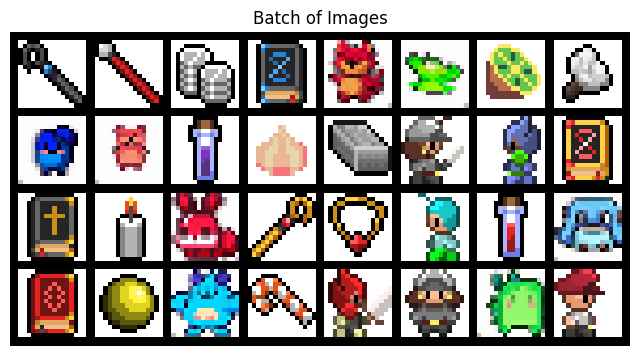

In [18]:
grid = vutils.make_grid(
    images,
    padding=2,
    normalize=True
)

'''
C: channels
H: height
W: width
B: batch size
'''
# CHW -> HWC for matplotlib
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [20]:
image_dim = 16 * 16 * 3  # 768

#### Simple GAN

In [21]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid() # outputs 0 to 1
        )

    def forward(self, x):
        return self.disc(x)

netD = Discriminator(image_dim).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)    

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [22]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, img_dim),
            nn.Tanh()  # outputs -1 to 1
        )

    def forward(self, x):
        return self.gen(x)
    
image_dim = 16 * 16 * 3  # 768

# Create the generator
netG = Generator(z_dim, image_dim).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=768, bias=True)
    (5): Tanh()
  )
)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils

# Disable deterministic mode (same as yours)
torch.use_deterministic_algorithms(False)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

real_label = 1.
fake_label = 0.

fixed_noise = torch.randn(batch_size, z_dim).to(device)

# Tracking
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (real, _) in enumerate(loader):

        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        # Real batch
        real = real.view(-1, image_dim).to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, device=device)

        output = netD(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake batch
        noise = torch.randn(b_size, z_dim).to(device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants D(fake)=1

        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        ############################
        # Logging
        ###########################
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        ############################
        # Save generated images (optional)
        ###########################
        if iters % 500 == 0:
            with torch.no_grad():
                fake_vis = netG(fixed_noise)
                fake_vis = fake_vis.view(-1, 3, 16, 16).cpu()
            img_list.append(vutils.make_grid(fake_vis, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/2794]	Loss_D: 15.3082	Loss_G: 0.6794	D(x): 0.0717	D(G(z)): 0.5065 / 0.5069
[0/5][50/2794]	Loss_D: 0.8783	Loss_G: 0.5693	D(x): 1.0000	D(G(z)): 0.5845 / 0.5659
[0/5][100/2794]	Loss_D: 0.8190	Loss_G: 0.6022	D(x): 1.0000	D(G(z)): 0.5591 / 0.5476
[0/5][150/2794]	Loss_D: 0.8072	Loss_G: 0.6020	D(x): 1.0000	D(G(z)): 0.5539 / 0.5477
[0/5][200/2794]	Loss_D: 0.6667	Loss_G: 0.7418	D(x): 0.9982	D(G(z)): 0.4857 / 0.4762
[0/5][250/2794]	Loss_D: 0.6627	Loss_G: 0.7478	D(x): 1.0000	D(G(z)): 0.4845 / 0.4734
[0/5][300/2794]	Loss_D: 0.8155	Loss_G: 0.6065	D(x): 1.0000	D(G(z)): 0.5576 / 0.5452
[0/5][350/2794]	Loss_D: 1.1130	Loss_G: 0.4164	D(x): 1.0000	D(G(z)): 0.6714 / 0.6594
[0/5][400/2794]	Loss_D: 1.3970	Loss_G: 0.4485	D(x): 0.8953	D(G(z)): 0.4298 / 0.6386
[0/5][450/2794]	Loss_D: 0.9356	Loss_G: 0.5172	D(x): 1.0000	D(G(z)): 0.6076 / 0.5962
[0/5][500/2794]	Loss_D: 0.8798	Loss_G: 0.5554	D(x): 1.0000	D(G(z)): 0.5851 / 0.5738
[0/5][550/2794]	Loss_D: 0.6960	Loss_G: 0.7085	D(x): 

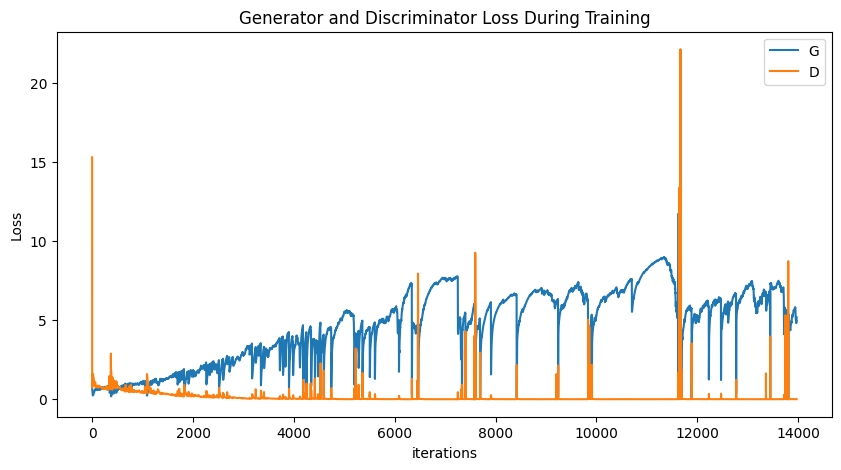

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

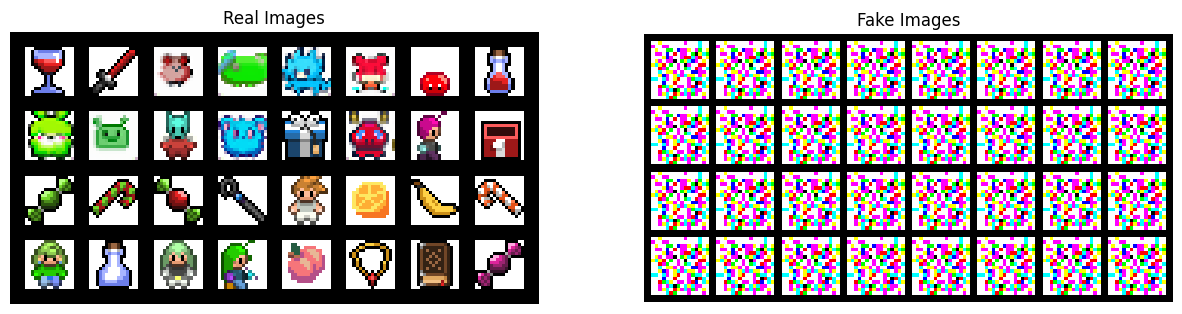

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

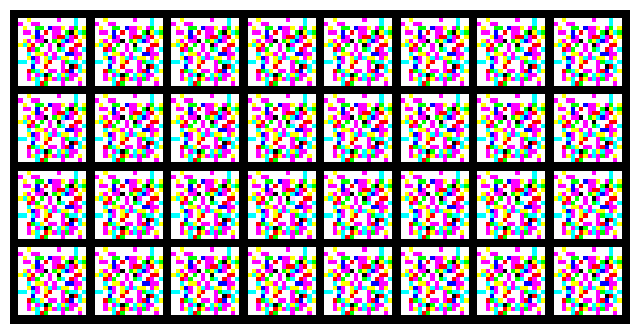

In [26]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())